In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np
import pandas as pd
import re

from matplotlib.patches import Rectangle
from pathlib import Path

In [2]:
def extract_years(dates):
    # Extract the first and last years from a "dates_covered" string
    start, end = re.findall(r"\b\d{4}\b", dates)[:2]
    return int(start), int(end)

In [3]:
# Set path. We are looking at tab 1 and tab 2 of the FundingAgencyStats googledoc
root_p = Path("/home/neuromod/funders_project")
data_p = root_p / "data"
tab1_p = data_p / "FundingAgencyStats - summary_table.csv"
tab2_p = data_p / "FundingAgencyStats - Transparent_scale_rating.csv"
figures_p = root_p / "figures"
figures_p.mkdir(parents=True, exist_ok=True)

In [4]:
# Load data
tab1_df = pd.read_csv(tab1_p, header=1)
tab1_df["english_data"] = tab1_df["english_data (e.g. if data_type = report, is the report in English?)"]

tab2_df = pd.read_csv(tab2_p, header=1)
tab2_df["Clear"] = tab2_df["Clear_DP"]
tab2_df["Findable"] = tab2_df["Findable_DP"]

In [5]:
# Get the frequency of each data type
data_type_counts = tab1_df['data_type'].value_counts().reset_index()

# Rename the columns for clarity
data_type_counts.columns = ['data_type', 'count']

# Calculate percentages
data_type_counts['percentage'] = (data_type_counts['count'] / data_type_counts['count'].sum()) * 100
data_type_counts

,data_type,count,percentage
0,tabular,10,45.454545
1,annual_report,6,27.272727
2,list/portal,2,9.090909
3,portal,2,9.090909
4,report,1,4.545455
5,annual_report/list,1,4.545455


In [6]:
# Calculate the widest range of data available per funder
# Extract start and end of funding years
tab1_df[["start_year", "end_year"]] = (
    tab1_df["dates_covered"].apply(extract_years).apply(pd.Series)
)
tab1_df.head()

,person_summarising,Country,Funder,data_type,data_downloadable?,dates_covered,neuro_specific,age,gender,disability,...,all applicants,longitudinal,reusable,accessible,clear,findable,TOTAL,english_data,start_year,end_year
0,NC,UK,MRC,tabular,1,2014-2021,0,1,1,1,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1,2014,2021
1,NC,UK,The Royal Society,annual_report,1,2015-2021,0,0,1,1,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1,2015,2021
2,NC,UK,BBSRC,tabular,1,2014-2021,0,1,1,1,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1,2014,2021
3,NC,UK,The Wellcome Trust,tabular,1,2021-2023,0,0,1,1,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1,2021,2023
4,NC,UK,The Wellcome Trust,annual_report,1,2016-2020,0,1,1,1,...,0.0,1.0,1.0,1.0,NaN,NaN,NaN,1,2016,2020


In [7]:
# Keep only the columns from tab1 that are not included in the scale (tab2)
cols_of_interest = [
    "neuro_specific",
    "summary_funding",
    "per_group_funding",
    "grant_duration",
    "dei_eo_page",
    "parental_leave",
    "english_data",
]

In [8]:
# Group by funder, using 'max' for the columns of interest and min/max for the years
grouped_df = tab1_df.groupby("Funder").agg(
    {**{col: 'max' for col in cols_of_interest},  # Max for the columns of interest
     'start_year': 'min',  # Earliest start year
     'end_year': 'max'}    # Latest end year
).reset_index()

grouped_df.describe()

,neuro_specific,summary_funding,per_group_funding,grant_duration,dei_eo_page,parental_leave,english_data,start_year,end_year
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.466667,0.733333,0.466667,0.400000,0.733333,0.866667,0.800000,2009.733333,2022.866667
std,0.516398,0.457738,0.516398,0.507093,0.457738,0.351866,0.414039,7.506822,1.187234
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1993.000000,2021.000000
25%,0.000000,0.500000,0.000000,0.000000,0.500000,1.000000,1.000000,2005.000000,2022.500000
50%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2014.000000,2023.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000,2023.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2017.000000,2025.000000


In [9]:
# Merge tab1 data with tab2
merged_df = pd.merge(grouped_df, tab2_df, on='Funder', how='inner')
merged_df.head()

,Funder,neuro_specific,summary_funding,per_group_funding,grant_duration,dei_eo_page,parental_leave,english_data,start_year,end_year,...,Clear_NC,Findable_NC,Clear_reliability,Findable_reliability,Unnamed: 16,Total score DP,Total score NC,Legend,Clear,Findable
0,ANR,0,1,1,0,0,0,0,2015,2023,...,1,1,Y,Y,NaN,7,7,NaN,1,1
1,BBSRC,0,1,0,0,1,0,1,2014,2021,...,1,1,Y,Y,NaN,10,10,Bronze (1-5),1,1
2,DFG,0,1,0,0,1,1,0,2013,2024,...,1,1,Y,Y,NaN,7,7,NaN,1,1
3,ERC,1,1,1,1,1,1,1,2007,2024,...,1,1,Y,Y,NaN,8,8,NaN,1,1
4,FNRS,1,1,0,0,1,1,0,2015,2023,...,1,1,Y,Y,NaN,8,8,NaN,1,1


In [10]:
# Create plot of funding over time
merged_df["years_range"] = merged_df.apply(
        lambda row: list(range(row["start_year"], row["end_year"] + 1)), axis=1
    )

years_df = merged_df.explode("years_range").rename(
        columns={"years_range": "year"}
    )

# Count the number of funders for each year
yearly_counts = years_df.groupby("year")["Funder"].nunique().reset_index()

In [11]:
# Let's filter to only include years up to 2023
yearly_counts = yearly_counts[yearly_counts["year"] <= 2023]

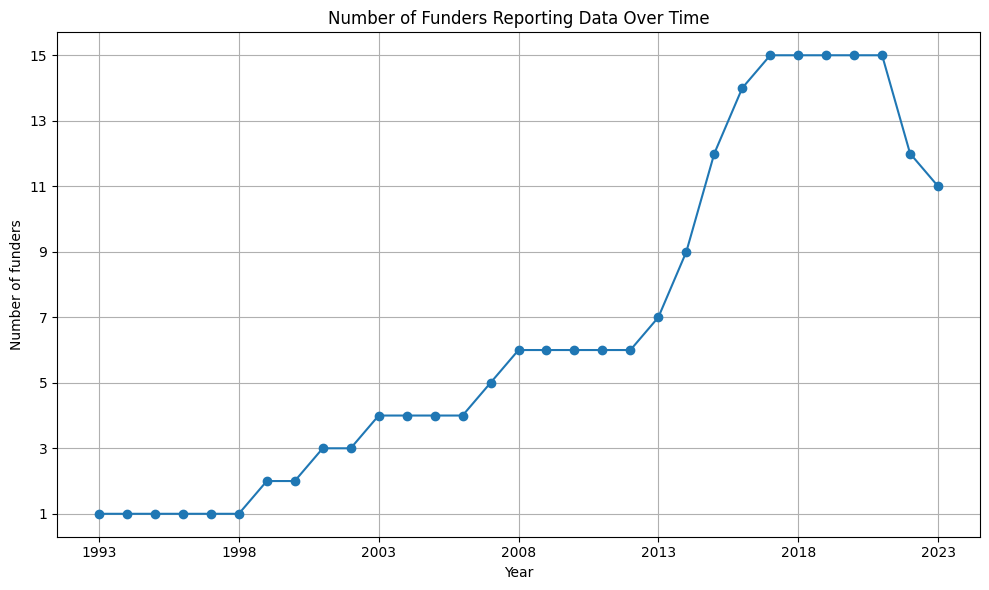

In [12]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts["year"], yearly_counts["Funder"], marker="o")
plt.title("Number of Funders Reporting Data Over Time")
plt.xlabel("Year")
plt.ylabel("Number of funders")
plt.grid(True)
plt.xticks(ticks=range(1993, 2024, 5))
plt.yticks(ticks=range(1, 16, 2))
plt.tight_layout()
plt.savefig(figures_p / "funding_over_time.png",dpi=300)
plt.show()

In [13]:
scale_cols = [
    "Gender",
    "Age/career stage",
    "Ethnicity",
    "Disability",
    "Applicants(awardees+rejected)",
    "Reusable",
    "Clear",
    "Findable"
]

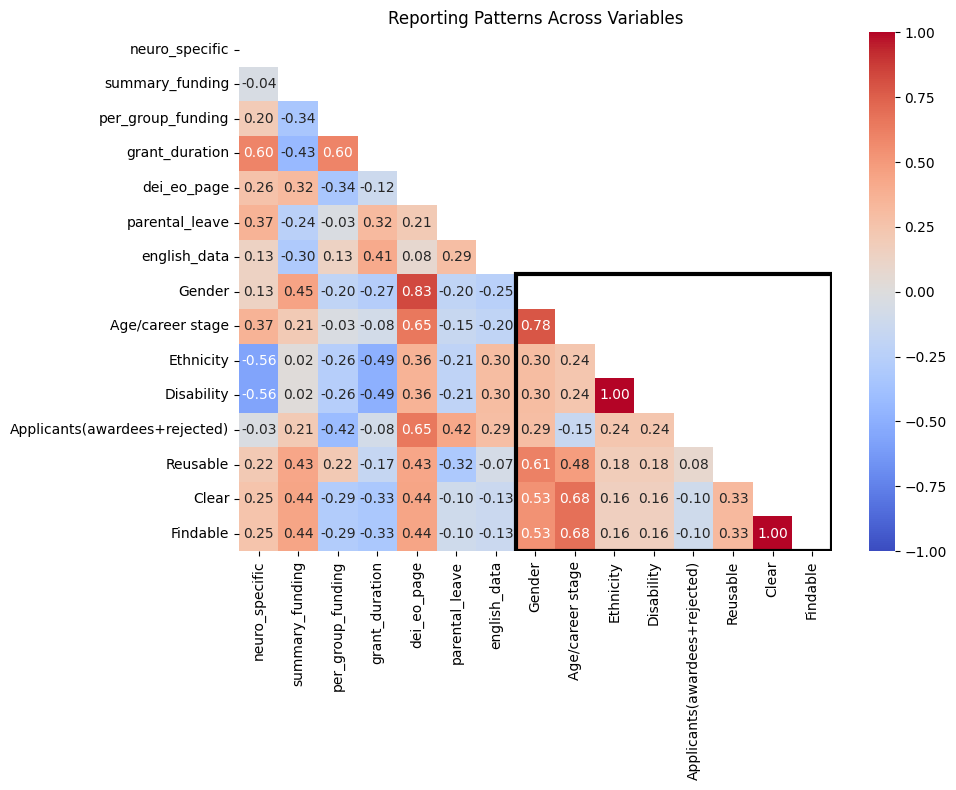

In [14]:
all_cols = cols_of_interest + scale_cols
correlation_matrix = merged_df[all_cols].corr()

mask = np.triu(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", mask=mask
)


# Find the indices of the scale_cols in the all_cols list
indices = [all_cols.index(col) for col in scale_cols]

# Get the coordinates of the top-left and bottom-right corners of the box
x0, y0 = min(indices), min(indices)
x1, y1 = max(indices) + 1, max(indices) + 1  # +1 because heatmap indexing starts at 0

# Add the black box using a patch
rect = Rectangle((x0, y0), x1 - x0, y1 - y0, 
                 linewidth=3, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.title("Reporting Patterns Across Variables")
plt.tight_layout()
plt.savefig(figures_p / "correlation_matrix.png",dpi=300,)
plt.show()

In [15]:
funders_per_country = merged_df.groupby('Country')['Funder'].nunique().reset_index()
funders_per_country.columns = ['Country', 'num_funders']
funders_per_country['Country'] = funders_per_country['Country'].replace('UK', 'United Kingdom')
funders_per_country

,Country,num_funders
0,Belgium,2
1,EU,2
2,France,1
3,Germany,1
4,Italy,1
5,Netherlands,1
6,Slovakia,1
7,Sweden,1
8,Switzerland,1
9,United Kingdom,4


In [16]:
# Load data from Natural Earth, to create a map
world = gpd.read_file(data_p / "geo_data/ne_110m_admin_0_countries.shp")
#print(world.columns.tolist())
europe = world[world['CONTINENT'] == 'Europe']
europe.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
18,Admin-0 country,1,2,Russia,RUS,0,2,Sovereign country,1,Russia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((178.7253 71.0988, 180 71.51571..."
21,Admin-0 country,1,3,Norway,NOR,0,2,Sovereign country,None,Norway,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
43,Admin-0 country,1,2,France,FR1,1,2,Country,1,France,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-51.6578 4.15623, -52.24934 3...."
110,Admin-0 country,1,3,Sweden,SWE,0,2,Sovereign country,1,Sweden,...,None,None,None,None,None,None,None,None,None,"POLYGON ((11.02737 58.85615, 11.46827 59.43239..."
111,Admin-0 country,1,4,Belarus,BLR,0,2,Sovereign country,1,Belarus,...,None,None,None,None,None,None,None,None,None,"POLYGON ((28.17671 56.16913, 29.22951 55.91834..."


In [17]:
# Merge the funders data with the Europe geo data
merged = europe.merge(funders_per_country, how='left', left_on='SOVEREIGNT', right_on='Country')

# Fill NaN with 0 for countries with no initial funders
merged["num_funders"] = merged["num_funders"].fillna(0)

# Add 2 to every country to reflect the 2 EU-wide funders
merged["num_funders_plus_eu_wide"] = merged["num_funders"]+2

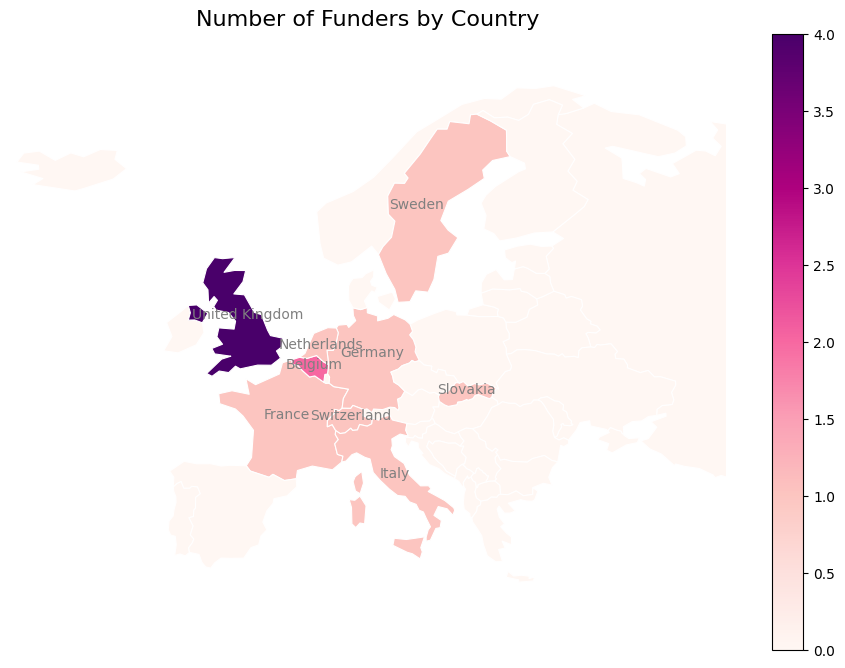

In [18]:
merged["num_funders"] = merged["num_funders"].fillna(0)

# Plot the map with a color gradient based on the number of funders
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(
    column='num_funders',  
    cmap='RdPu',          
    linewidth=0.8,          
    edgecolor='white',      
    legend=True,            
    ax=ax
)

# Zoom in using longtude and latitude ranges for Europe
ax.set_xlim([-25, 45])  
ax.set_ylim([30, 75])

# Add labels for countries with data only
for idx, row in merged.iterrows():
    if row['num_funders'] > 0: 
        # Get the centroid of the country for label placement
        point = row['geometry'].representative_point()
        ax.annotate(
            text=row['SOVEREIGNT'], 
            xy=(point.x, point.y),
            ha='center', fontsize=10, color='grey')

ax.set_title('Number of Funders by Country', fontdict={'fontsize': 16})
ax.set_axis_off()
plt.savefig(figures_p / 
    "funders_map.png",
    dpi=300,
)
plt.show()

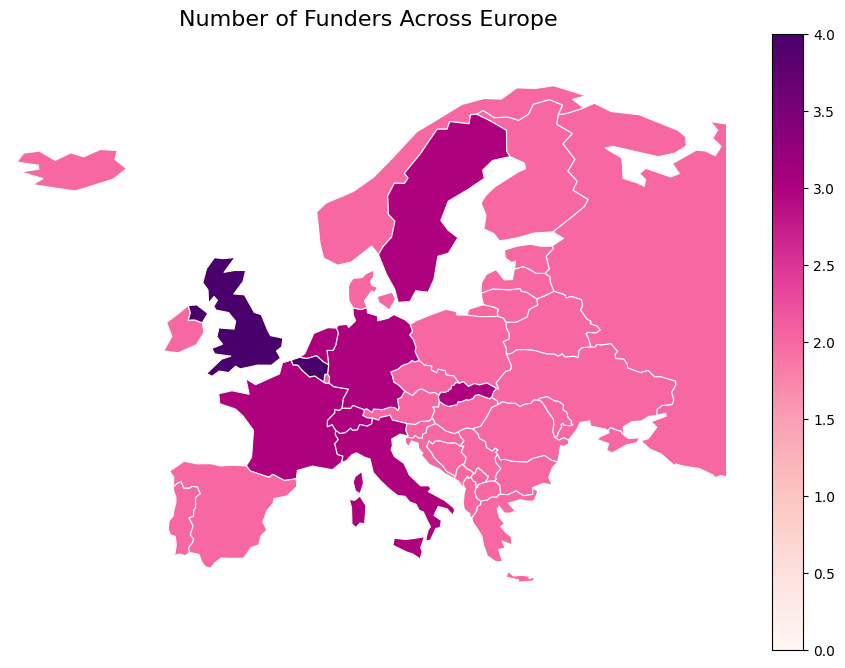

In [19]:
merged["num_funders_plus_eu_wide"] = merged["num_funders_plus_eu_wide"].fillna(0)

# Use Normalize to set the scale starting at 0
norm = mcolors.Normalize(vmin=0, vmax=merged["num_funders"].max())

# Plot the map with a color gradient based on the number of funders
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(
    column='num_funders_plus_eu_wide',  
    cmap='RdPu',          
    linewidth=0.8,          
    edgecolor='white',      
    legend=True,            
    ax=ax,
    norm=norm
) 

# Zoom in using longtude and latitude ranges for Europe
ax.set_xlim([-25, 45])  
ax.set_ylim([30, 75])

ax.set_title('Number of Funders Across Europe', fontdict={'fontsize': 16})
ax.set_axis_off()
plt.savefig(figures_p / 
    "funders_map-include_eu_wide.png",
    dpi=300,
)
plt.show()